In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, log_loss, accuracy_score
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import unittest
import pandas as pd
from sklearn.utils import resample
from solution import MultinomialLogReg, OrdinalLogReg
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

## Preprocess the data

In [72]:
np.random.seed(42)
# Read the data
df = pd.read_csv("dataset.csv", sep=";")
df_og =df.copy()
# Encode the data
encoder_labs = LabelEncoder()
df["ShotType"] = encoder_labs.fit_transform(df["ShotType"])
encoder = OneHotEncoder(sparse_output=False, drop="first")
for col in ["Competition", "PlayerType", "Movement"]:
    # Fit and transform the column (convert to dense matrix)
    encoded = encoder.fit_transform(df[[col]])
    # Create new column names for the encoded columns
    encoded_columns = encoder.get_feature_names_out([col])
    # Convert the encoded array to a DataFrame with the new column names
    encoded_df = pd.DataFrame(encoded, columns=encoded_columns)
    # Drop the original column and concatenate the new encoded columns
    df = pd.concat([df.drop(columns=[col]), encoded_df], axis=1)


# Testing functions on the dataset

In [73]:
#################################
# Testing if the regressions work
#################################

## TODO switch to cross validation and use it in the report 

# Split into train and test
train, test = train_test_split(df, test_size=0.3, stratify=df["ShotType"])
# Get the features and target
X_train,y_train  = train.drop(columns=["ShotType"]), train["ShotType"]
X_test, y_test = test.drop(columns=["ShotType"]), test["ShotType"]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train[["Angle", "Distance"]])
X_train.loc[:, ["Angle", "Distance"]] = scaler.transform(X_train[["Angle", "Distance"]])
X_test.loc[:, ["Angle", "Distance"]] = scaler.transform(X_test[["Angle", "Distance"]])
# build the model
model = MultinomialLogReg()
model_pred = model.build(X_train, y_train)
pred = model_pred.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
print(classification_report(y_test, pred_classes,zero_division=1))
# Use the other one
model = OrdinalLogReg()
model_pred = model.build(X_train, y_train)
pred = model_pred.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
print(classification_report(y_test, pred_classes,zero_division=1))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       917
           1       0.50      0.13      0.21        30
           2       0.35      0.28      0.31       119
           3       0.60      0.77      0.67       292
           4       0.59      0.24      0.34       132
           5       0.00      0.00      1.00        18

    accuracy                           0.73      1508
   macro avg       0.48      0.38      0.56      1508
weighted avg       0.71      0.73      0.72      1508

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       917
           1       1.00      0.00      0.00        30
           2       0.33      0.03      0.06       119
           3       0.50      0.78      0.61       292
           4       0.23      0.05      0.08       132
           5       1.00      0.00      0.00        18

    accuracy                           0.70      1508
   macro avg       0.64

# Part 2.1

,Transition,TwoLegged,Angle,Distance,Competition_NBA,Competition_SLO1,Competition_U14,Competition_U16,PlayerType_F,PlayerType_G,Movement_drive,Movement_no
Transition,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TwoLegged,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.880078
Angle,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Competition_NBA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Competition_SLO1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Competition_U14,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Competition_U16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
PlayerType_F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.712959,NaN,NaN
PlayerType_G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.712959,1.000000,NaN,NaN


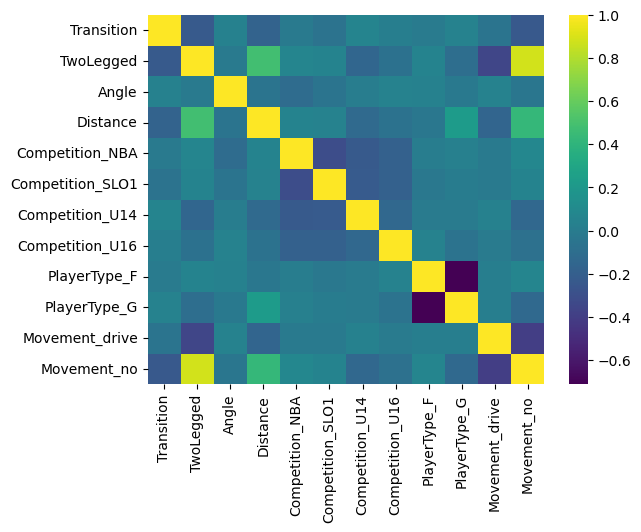

In [74]:
# Which column to use as reference? (in the model it's the last one)
y = df["ShotType"].copy()
y.value_counts(), df_og["ShotType"].value_counts()
# y.loc[y == 5] = 99
# y.loc[y == 2] = 5
# y.loc[y == 99] = 2
# y.value_counts(), df_og["ShotType"].value_counts()
m = 100
X = df.drop(columns = "ShotType")
y = df["ShotType"]
# Scaling the data
scaler = StandardScaler()
X.loc[:,["Angle", "Distance"]] = scaler.fit_transform(X.loc[:,["Angle", "Distance"]])

cor = X.corr()
sns.heatmap(X.corr(), cmap="viridis")
# Drop some stuff
display(cor[abs(cor) > 0.7]) 
X = X.drop(columns=["TwoLegged", "PlayerType_F"])

In [75]:
betas = []
model = MultinomialLogReg()
for i in tqdm(range(m)):
    X_bs, y_bs = resample(X,y)
    model_pred = model.build(X_bs, y_bs)
    betas.append(model_pred.beta)
betas_means = np.mean(betas, axis=0)
betas_stds = np.std(betas, axis=0)

# Save the results
np.save("betas_means.npy", betas_means)
np.save("betas_stds.npy", betas_stds)

100%|██████████| 100/100 [18:32<00:00, 11.13s/it]


In [76]:
betas_means = np.load("betas_means.npy") 
betas_stds = np.load("betas_stds.npy") 
betas_means = np.vstack([betas_means ,np.zeros_like(betas_means[0]) ]) 
betas_stds = np.vstack([betas_stds ,np.zeros_like(betas_means[0])]) 

In [77]:
# Define the column names, adding 'intercept' at the beginning
columns_with_intercept = ["intercept"] + list(X.columns) 
 
# Create the DataFrame with the intercept column first
df_betas_means = pd.DataFrame(columns=columns_with_intercept, data=betas_means)
 

labs = [i for i in range(df["ShotType"].nunique())]
shotTypes_col = encoder_labs.inverse_transform(labs) 
# HERE you have to set the correct one to 0-s, and also have to shuffle the SE-s
df_betas_means["ShotType"] = shotTypes_col
# df_betas_means["ShotType"].loc[df_betas_means["ShotType"] == "tip-in"] = "tmp"
# df_betas_means["ShotType"].loc[df_betas_means["ShotType"] == "hook shot"] = "tip-in"
# df_betas_means["ShotType"].loc[df_betas_means["ShotType"] == "tmp"] = "hook shot"
display(df_betas_means)
excluded_col = "ShotType"
df_exp = df_betas_means.copy()
for col in df_betas_means.columns:
    if col != excluded_col:
        df_exp[col] = np.exp(df_betas_means[col])
# REPORT: FMAKE A TABLE (OR GRAPH) FOR EACH OF THE ORIGINAL FEATUERES (BEFORE HOT-ENCODED), AND ONE TABLE (OR GRAPH) FOR ANGLE AND DISTANCE
# WHEN WRITIN THE REPORT LOOK AGAIN AT THE DEFINITIONS OF BASKETBALL STUFF IN THE PAPER
# INTERCEPT INTERPRETATION
# MAYBE PLOT SOME DENSITIES OF BETAS
df_exp

,intercept,Transition,Angle,Distance,Competition_NBA,Competition_SLO1,Competition_U14,Competition_U16,PlayerType_G,Movement_drive,Movement_no,ShotType
0,17.255769,-0.507563,0.358345,10.324612,0.838668,-0.051291,7.112363,2.407874,-0.001143,-7.338030,-4.761135,above head
1,-6.552727,0.218330,0.203422,3.378670,1.083120,-0.171034,-7.247005,-0.498647,-0.509396,-1.305757,10.646738,dunk
2,-2.100476,-0.929866,0.105411,8.173858,0.090484,-0.068733,5.449673,1.351531,-0.416048,-1.669960,12.689608,hook shot
3,14.042689,-0.192682,0.673860,5.844610,1.115097,0.462030,7.290077,3.039069,0.114629,7.124811,-6.656185,layup
4,16.629600,-0.354699,0.368441,9.873909,1.005080,-0.406270,8.063798,3.027552,0.275777,7.587779,-6.925461,other
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,tip-in


,intercept,Transition,Angle,Distance,Competition_NBA,Competition_SLO1,Competition_U14,Competition_U16,PlayerType_G,Movement_drive,Movement_no,ShotType
0,3.119502e+07,0.601961,1.430959,30473.465713,2.313283,0.950002,1227.043615,11.110313,0.998858,0.000650,0.008556,above head
1,1.426221e-03,1.243997,1.225589,29.331726,2.953882,0.842793,0.000712,0.607352,0.600859,0.270967,42055.181144,dunk
2,1.223982e-01,0.394607,1.111167,3547.001560,1.094704,0.933576,232.682114,3.863336,0.659649,0.188255,324359.494450,hook shot
3,1.255054e+06,0.824744,1.961795,345.367982,3.049864,1.587293,1465.683976,20.885798,1.121457,1242.412726,0.001286,layup
4,1.667798e+07,0.701384,1.445480,19417.084056,2.732126,0.666130,3177.336167,20.646631,1.317554,1973.924294,0.000982,other
5,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,tip-in


## Part 2.2

In [109]:
def multinomial_bad_ordinal_good(num_classes=5, num_data_points=500, num_features=30):
    # Generate some random features, from the uniform distribution
    data = np.random.uniform(0,num_classes,(num_data_points, num_features))
    cols = [f"{i}" for i in range(num_features)]
    df = pd.DataFrame(data, columns=cols)
    # Assign the target based on the sum of the featues 
    feature_mean = df.mean(axis=1) + np.random.randn(len(df)) * 0.1 # Add a bit of gaussian noise
    # Assign the class based on the mean quantiles
    df["target"] = pd.qcut(feature_mean, q=num_classes, labels=False, duplicates="drop")
    return df

In [112]:
df = multinomial_bad_ordinal_good(5,300)
train, test = train_test_split(df, test_size=0.3, stratify=df["target"])
X_train,y_train  = train.drop(columns=["target"]), train["target"]
X_test, y_test = test.drop(columns=["target"]), test["target"]
model = MultinomialLogReg()
model_pred = model.build(X_train, y_train)
pred = model_pred.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
print(accuracy_score(y_test, pred_classes))
print(log_loss(y_test, pred))

# Use the other one
model = OrdinalLogReg()
model_pred = model.build(X_train, y_train)
pred = model_pred.predict(X_test)

pred_classes = np.argmax(pred, axis=1)
print(accuracy_score(y_test, pred_classes))
print(log_loss(y_test, pred))

0.3111111111111111
2.170181622353088
0.2
19.792775834277148


c:\Users\marko\Desktop\MLDS\machine-learning-for-data-science-assignments\Generalized linear models\solution.py:109: RuntimeWarning: divide by zero encountered in log
  l -= np.log(logistic_cdf(tresholds[j + 1] - u[i]) - logistic_cdf(tresholds[j] - u[i]))
c:\Users\marko\miniconda3\envs\mlds\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [ ]:
m = 200
accs_MN = []
log_losses_MN = []
accs_ORD = []
log_losses_ORD = []
for i in tqdm(range(m)):
    # Test the function, it can't be a too large dataset, otherwise the work the same, report accuracy and F1
    df = multinomial_bad_ordinal_good(5,300)
    train, test = train_test_split(df, test_size=0.3, stratify=df["target"])
    X_train,y_train  = train.drop(columns=["target"]), train["target"]
    X_test, y_test = test.drop(columns=["target"]), test["target"]
    model = MultinomialLogReg()
    model_pred = model.build(X_train, y_train)
    pred = model_pred.predict(X_test)
    pred_classes = np.argmax(pred, axis=1)
    accs_MN.append(accuracy_score(y_test, pred_classes))
    log_losses_MN.append(log_loss(y_test, pred))

    # Use the other one
    model = OrdinalLogReg()
    model_pred = model.build(X_train, y_train)
    pred = model_pred.predict(X_test)

    pred_classes = np.argmax(pred, axis=1)
    accs_ORD.append(accuracy_score(y_test, pred_classes))
    log_losses_ORD.append(log_loss(y_test, pred))

print(np.mean(accs_MN), (np.std(accs_MN)))
print(np.mean(accs_ORD), (np.std(accs_ORD)))
print(np.mean(log_losses_MN), (np.std(log_losses_MN)))
print(np.mean(log_losses_ORD), (np.std(log_losses_ORD)))

## Part 3

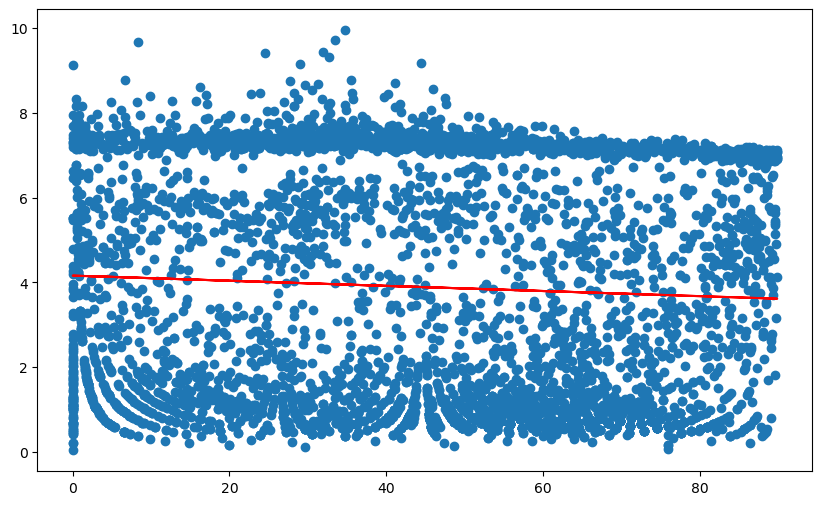

In [ ]:
import matplotlib.pyplot as plt
class LinearRegression():
    def build(self, x,y):
        # Add intercept
        y = np.array(y).reshape(-1,1)
        x = np.array(x).reshape(-1,1)
        x = np.c_[np.ones_like(x),x]
        # Use the least-squares formula to get betas
        self.beta = (np.linalg.inv(x.T @ x) @ x.T) @ y
        self.hat = x @(np.linalg.inv(x.T @ x) @ x.T)
        
    def predict(self,x):
        x = np.array(x).reshape(-1,1)
        x = np.c_[np.ones_like(x),x]

        return (self.beta.T @ x.T).flatten()
    

# Get the x ans y 
df = pd.read_csv("dataset.csv", sep=";")
y = df["Distance"].values
x = df["Angle"].values

model = LinearRegression()
# indices = y < y.mean()

# y = y[indices]
# x = x[indices]
model.build(x,y)
preds = model.predict(x)

plt.figure(figsize=(10,6))
plt.plot(x, preds, color="red")
plt.scatter(x,y)
plt.show()

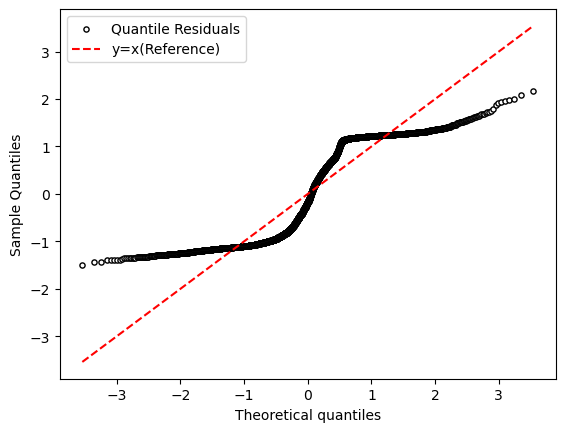

In [ ]:
from scipy.stats import norm
# normal q-q plot (8.7.4)
# Get the basic residuals
response_residuals = y - preds
# Then we need the pearson residuals
quantile_residuals = response_residuals  / np.std(response_residuals)
quantile_residuals = sorted(quantile_residuals)
N = len(quantile_residuals)
probabilites = np.linspace(1/(N), N/(N+1), N)
quantiles_theory = norm.ppf(probabilites)
# Step 3: Plot Q-Q plot
plt.scatter(quantiles_theory, quantile_residuals, label="Quantile Residuals",
             color="white", s=14, edgecolors="k")
plt.plot(quantiles_theory, quantiles_theory, 'r--', label="y=x(Reference)")
plt.ylabel("Sample Quantiles")
plt.xlabel("Theoretical quantiles")
plt.legend()
plt.show()
# Pretty clearly the distribution of residuals is not normal, it is similar to the og distribution

Text(0, 0.5, 'Residuals')

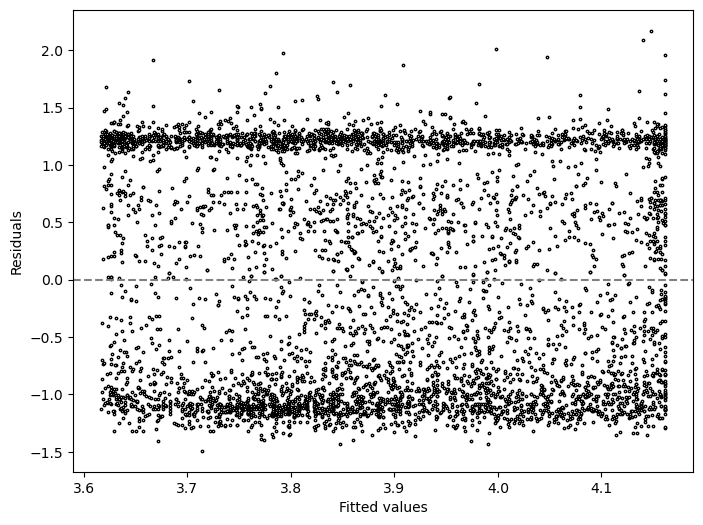

In [ ]:
# residuals vs fitted values, quantile residuals
# Plot residuals vs. fitted values
plt.figure(figsize=(8,6))
plt.scatter(preds,quantile_residuals, color="white", edgecolors="black", s = 3)
plt.axhline(0, color="grey", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")



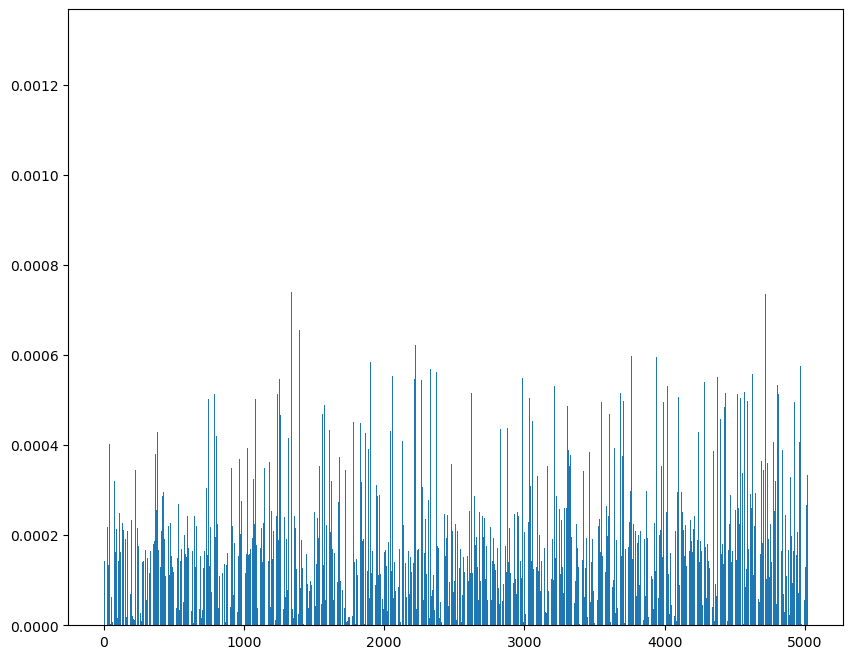

In [ ]:
# Cooks distance plot
# Get the hat matrix
mse = np.mean((response_residuals)**2)
diags = np.diag(model.hat)
cook = response_residuals**2 / (2 * mse)  * diags /(1-diags)**2

plt.figure(figsize=(10,8))
plt.bar(range(len(cook)), cook)
plt.show()

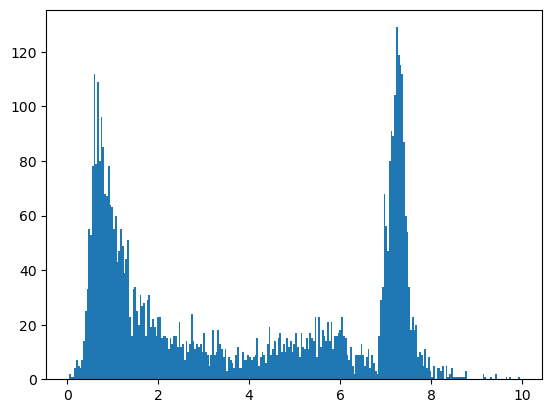

In [ ]:
# plot the distribution of shot lengths
import matplotlib.pyplot as plt

plt.hist(y, bins = 255)
plt.show()